In [2]:
libs <- c(
    'tidyverse',
    'stringr',
    'GenomicRanges',
    'RPostgreSQL',
    'doMC',
    'numbers',
    'doParallel',
    'Matrix',
    'fst'
)

for (lib in libs) {
        if (!require(lib, character.only = TRUE, quietly = TRUE)) {
            install.packages(lib, repos='http://cran.us.r-project.org')
        }
}

library(BSgenome.Hsapiens.UCSC.hg38)
hg38 = BSgenome.Hsapiens.UCSC.hg38

source("my_R_functions/utility_functions.R")
source("my_R_functions/stat_functions.R")
source("my_R_functions/plot_functions.R")
#source("/ssd/mrichard/github/BDDS/trenadb/src/utils.R")
source("/ssd/mrichard/github/BDDS/footprints/testdb/src/dbFunctions.R")

At this point we have a few things:

* A subset of FIMO for only those motifs in our ChipSeq set, with:
    * A 9-to-1 ratio of negative to positive ChipSeq hits
    * Data about where there are hits and where there aren't
    * Data about which motifs overlap with HINT/Wellington and, for those that do, their number of overlaps and greatest magnitude score
* Maps between TFs and motifs
* A file that groups together motifs in families (based on class)

Now we're going to "annotate" that first dataset by overlaying the information in the other two. We'll load the TF-motif map first:

In [5]:
load("Rdata_files/Tfmotifmap.Rdata")

# Load the new TF-motif mapping
#TF.motif.pairs <- readRDS("../BDDS/trenadb/fimo/2017_08_23_Motif_TF_Map.RDS")
#names(TF.motif.pairs) <- c("motif","tfs")
head(TFs.to.motifs)


$ATF2
[1] "Ggallus-jaspar2016-MAFG::NFE2L1-MA0089.1" 
[2] "Hsapiens-jaspar2016-ATF7-MA0834.1"        
[3] "Hsapiens-jaspar2016-JUNB-MA0490.1"        
[4] "Hsapiens-jaspar2016-JUND-MA0491.1"        
[5] "Hsapiens-jaspar2016-JUND(var.2)-MA0492.1" 
[6] "Mmusculus-jaspar2016-Bach1::Mafk-MA0591.1"
[7] "Mmusculus-jaspar2016-Creb5-MA0840.1"      
[8] "Mmusculus-jaspar2016-Nfe2l2-MA0150.2"     

$ATF3
[1] "Hsapiens-jaspar2016-JDP2-MA0655.1"       
[2] "Hsapiens-jaspar2016-JDP2(var.2)-MA0656.1"
[3] "Mmusculus-jaspar2016-Atf3-MA0605.1"      

$BATF
[1] "Hsapiens-jaspar2016-BATF::JUN-MA0462.1" 
[2] "Hsapiens-jaspar2016-BATF3-MA0835.1"     
[3] "Hsapiens-jaspar2016-JUN(var.2)-MA0489.1"

$BCL11A
[1] "Hsapiens-jaspar2016-RUNX2-MA0511.1"  "Mmusculus-jaspar2016-RUNX1-MA0002.2"

$BHLHE40
[1] "Hsapiens-jaspar2016-BHLHE40-MA0464.2"
[2] "Hsapiens-jaspar2016-MAX-MA0058.3"    
[3] "Hsapiens-jaspar2016-MNT-MA0825.1"    
[4] "Mmusculus-jaspar2016-Myc-MA0147.1"   
[5] "Mmusculus-jaspar2016-Npas2-MA0626.1" 

$CEBPB
[1] "Hsapiens-jaspar2016-CEBPA-MA0102.3" "Hsapiens-jaspar2016-CEBPB-MA0466.1"
[3] "Hsapiens-jaspar2016-CEBPB-MA0466.2"

Now for the families, we'll load a text file. Below, we're showing the top, but basically, it contains:

1. The motif name
2. The "class" of the motif
3. The family of the motif

In [6]:
load("Rdata_files/motif_class_pairs.Rdata") 

head(motif.class); nrow(motif.class)

motif,TF,class,family
MA0001.1,AGL3,Other Alpha-Helix,MADS
MA0002.1,RUNX1,Ig-fold,Runt
MA0003.1,TFAP2A,Zipper-Type,Helix-Loop-Helix
MA0004.1,Arnt,Basic helix-loop-helix factors (bHLH),PAS domain factors
MA0005.1,AG,Other Alpha-Helix,MADS
MA0006.1,Ahr::Arnt,Basic helix-loop-helix factors (bHLH),PAS domain factors


[1] 2049

Now we need to change our motif/class mapping somewhat; the motif "ID" is the shortened name, so we need to map to the longer names we now use for motifs. 

We'll do this using MotifDb to get a translation table for Jaspar motifs:

In [7]:
suppressMessages(library(MotifDb))

# Grab just Jaspar2016
jaspar.motifs <- subset(MotifDb, dataSource == "jaspar2016")

jaspar.df <- data_frame(Long.Name = names(jaspar.motifs),
                        Short.Name = trimws(values(jaspar.motifs)$providerName)                       
                       )
head(jaspar.df); nrow(jaspar.df)


Long.Name,Short.Name
Athaliana-jaspar2016-AGL3-MA0001.1,MA0001.1
Athaliana-jaspar2016-AGL3-MA0001.2,MA0001.2
Hsapiens-jaspar2016-RUNX1-MA0002.1,MA0002.1
Mmusculus-jaspar2016-RUNX1-MA0002.2,MA0002.2
Hsapiens-jaspar2016-TFAP2A-MA0003.1,MA0003.1
Hsapiens-jaspar2016-TFAP2A-MA0003.2,MA0003.2


[1] 1209

Now use the translation table to add the "Long.Name" column, then change it to "motifname" and remove the other things

In [8]:
fixed.motif.class <- motif.class %>% 
    left_join(jaspar.df, by = c("motif" = "Short.Name")) %>%
    select("motifname" = "Long.Name", class) 
head(fixed.motif.class); nrow(fixed.motif.class)

motifname,class
Athaliana-jaspar2016-AGL3-MA0001.1,Other Alpha-Helix
Hsapiens-jaspar2016-RUNX1-MA0002.1,Ig-fold
Hsapiens-jaspar2016-TFAP2A-MA0003.1,Zipper-Type
Mmusculus-jaspar2016-Arnt-MA0004.1,Basic helix-loop-helix factors (bHLH)
Athaliana-jaspar2016-AG-MA0005.1,Other Alpha-Helix
Mmusculus-jaspar2016-Ahr::Arnt-MA0006.1,Basic helix-loop-helix factors (bHLH)


[1] 2049

We also want to quickly remove any rows that have motifs not appearing in our dataset. First load it, then use semi_join

In [9]:
#load("/ssd/mrichard/data/all.TF.df.fimo.hint.well.seed20.10M.Rdata")
all.TF.df.fimo.hint.well <- read.fst("/ssd/mrichard/data/all.TF.df.fimo.hint.well.seed20.10M.fst")

In [12]:
filtered.motif.class <- semi_join(fixed.motif.class, all.TF.df.fimo.hint.well, by = "motifname")

In [13]:
nrow(filtered.motif.class)

[1] 257

Given our family/class info, we'll:

* Filter so it's only things in our motif-TF mapping
* Split double classes into singles using "mutate" to make a list and tidyr::unnest to unlist that
* Add a dummy variable of "1" to each, used for counting in a bit...
* Remove any duplicates using dplyr::distinct (**good function to remember!**)
* Use tidyr::spread (**another good one to remember!**) to essentially expand the data
    * The "class" is the key, so these become column names
    * The "dummy_yesno" is the value, so these become the values for columns
    * We use 0 as the "fill" value, so as each existing key-value pair retains its 1, any non-existent one gets a 0
        * For example, if Motif_1 has Class_1, the Value for that (row,column) pair is 1
        * If Motif_1 DOES NOT have Class_1, the Value for that (row,column) pair is 0

As a result, we now have a data frame where each row is a motif, every column is a class, and every entry is either 1 or 0. It's essentially a sparse matrix, but with an extra column that contains each motif name. 

In [14]:
filtered.motif.class %>%
    # clean up and subset to only relevant motifs
    mutate_all(str_trim) %>%
    # fix double classes
    mutate(class = str_split(class, "::")) %>% 
    unnest(class) %>%
    # create one-hot(ish, some double matches) version
    mutate(dummy_yesno = 1) %>%
    distinct %>%
    spread(class, dummy_yesno, fill = 0) ->
    motif_class_hot

In [15]:
summary(motif_class_hot)

  motifname         Basic helix-loop-helix factors (bHLH)
 Length:257         Min.   :0.0000                       
 Class :character   1st Qu.:0.0000                       
 Mode  :character   Median :0.0000                       
                    Mean   :0.1128                       
                    3rd Qu.:0.0000                       
                    Max.   :1.0000                       
 Basic leucine zipper factors (bZIP) C2H2 zinc finger factors
 Min.   :0.00000                     Min.   :0.0000          
 1st Qu.:0.00000                     1st Qu.:0.0000          
 Median :0.00000                     Median :0.0000          
 Mean   :0.09339                     Mean   :0.0856          
 3rd Qu.:0.00000                     3rd Qu.:0.0000          
 Max.   :1.00000                     Max.   :1.0000          
 Fork head / winged helix factors Helix-Turn-Helix  
 Min.   :0.0000                   Min.   :0.000000  
 1st Qu.:0.0000                   1st Qu.:0.000000  
 

In [16]:
str(motif_class_hot)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	257 obs. of  24 variables:
 $ motifname                               : chr  "Ggallus-jaspar2016-NFAT5-MA0606.1" "Hsapiens-jaspar2016-ATF7-MA0834.1" "Hsapiens-jaspar2016-BATF3-MA0835.1" "Hsapiens-jaspar2016-BATF::JUN-MA0462.1" ...
 $ Basic helix-loop-helix factors (bHLH)   : num  0 0 0 0 1 1 0 0 0 0 ...
 $ Basic leucine zipper factors (bZIP)     : num  0 1 1 1 0 0 1 0 1 0 ...
 $ C2H2 zinc finger factors                : num  0 0 0 0 0 0 0 0 0 1 ...
 $ Fork head / winged helix factors        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Helix-Turn-Helix                        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Heteromeric CCAAT-binding factors       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ High-mobility group (HMG) domain factors: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Homeo domain factors                    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Ig-fold                                 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ MADS box factors                        : num  0 0 0 0 0 0

Now that we have a Motif-Class mapping for our motifs, we're going to load our big FIMO-esque dataset and add the class information to it as "annotation"

## merge in TF classes

Immediately, we add our different classes to our FIMO-esque dataset, so now it has this information as well.

In [17]:
all.TF.df.fimo.hint.well.annotated <- left_join(all.TF.df.fimo.hint.well, motif_class_hot)

Joining, by = "motifname"


In [18]:
dim(all.TF.df.fimo.hint.well.annotated)
dim(all.TF.df.fimo.hint.well)

[1] 9999959      37

[1] 9999959      14

In [19]:
length(unique(all.TF.df.fimo.hint.well$motifname))

[1] 257

## merge in gc content

Now we want GC content, so we'll use GenomicRanges to write a function that uses the start/end/chrom to get the sequence, then basically count the C's and G's and get their frequencies (in percentage I think). 

We apply this to the whole BIG annotated dataset to add a "gc_content" column. This takes a while because it's like 15 million lines. 

In [157]:
# TODO: runs out of memory on pnr 49 dataset -- make more efficient?

In [20]:
get_gc_content <- function(start_col, end_col, chrom_col, b=100) {
    require(GenomicRanges)
    
    window_center <- round((start_col + end_col)/2)
    windows <- getSeq(hg38, paste0("chr",chrom_col), window_center-b, window_center+b)

    alph_freq <- alphabetFrequency(windows)
    gc_content <- rowSums(alph_freq[,c("C","G")])/(2*b+1)
    
    return(gc_content)
}

In [21]:
all.TF.df.fimo.hint.well.annotated %>%
    mutate("gc_content" = get_gc_content(start,endpos,chrom)) ->
    all.TF.df.fimo.hint.well.annotated

## merge in tss distance

We want to add info on the transcription start site (TSS), so we're going to connect to our genome database (hg38) and pull out all entries for protein coding genes. The info we'll grab is the chromosome, start/end/strand (location), and the gene name.

In [22]:
# Changed host to localhost
db_gtf <- dbConnect(PostgreSQL(), user= "trena", password="trena", dbname="hg38", host="localhost")
query <- "select * from gtf where moleculetype='gene' and gene_biotype='protein_coding'"
tss_raw_table <- dbGetQuery(db_gtf, query)[, c("chr", "gene_name", "start", "endpos","strand")]

To that initial table of all genes, we'll:

1. Add a "ref" column that looks at strand and decides whether to start at the start or end.
2. Grab just the "ref" and "chr" columns, renaming them to "chrom" and "ts_start"
3. Remove MT chromosome from the dataset
4. Remove the "chr" from chromosome using stringr::str_sub

So what we have is a 2-column data frame with chromosome number mapped to TSS

In [23]:
tss_raw_table %>%
    mutate(ref = ifelse(strand == '+', start, endpos)) %>%
    select("chrom" = "chr", "ts_start" = "ref") %>%
    filter(chrom != 'chrMT') %>%
    mutate(chrom=str_sub(chrom,  start = 4)) ->
    tss_tbl

We're using the GenomicRanges again, and we're making our giant annotated table into that object, plus our new TSS table. Why?? Because then we can use the "distanceToNearest" to find the nearest TSS to each motif!

In [24]:
motif_gr <- makeGRangesFromDataFrame(all.TF.df.fimo.hint.well.annotated, start.field="start", end.field="endpos")
tss_gr <- makeGRangesFromDataFrame(tss_tbl, start.field="ts_start", end.field="ts_start")
dist_to_nearest_tss <- distanceToNearest(motif_gr, tss_gr, select="arbitrary")
tss_dists <- mcols(dist_to_nearest_tss)[,1]

We add the TSS to the data, but we take the arc-sinh of it so as not to have it all skewed. 

In [25]:
all.TF.df.fimo.hint.well.annotated %>%
    mutate(asinh_tss_dist = asinh(tss_dists)) ->
    all.TF.df.fimo.hint.well.annotated

## Save data

In [164]:
# load("/ssd/mrichard/data/all.TF.df.fimo.hint.well.seed20.annotated.9.Rdata")

Before saving, we do a bit of data manipulation again:

* Change HINT/Wellington counts to fractions by dividing by the maximum vaue
    * Each is basically normalized
* Remove the counts themselves, now that we have the fractions
* Rearrange so that TF classes come last (using the "everything()" helper)
    * Note that the GC ontent and TSS distance come right beforehand

In [26]:
# change hint and wellington counts to fractions
# rearrange column order to keep TF classes last. 

all.TF.df.fimo.hint.well.annotated %>%
mutate(h_frac = h_count/max(h_count)) %>%
mutate(w_frac = w_count/max(w_count)) %>%
select(-one_of("h_count","w_count")) %>%
select(motifname:w_min_score, h_frac, w_frac, gc_content, asinh_tss_dist, everything()) ->
all.TF.df.fimo.hint.well.annotated

In [27]:
#save(all.TF.df.fimo.hint.well.annotated, file="/ssd/mrichard/data/all.TF.df.fimo.hint.well.seed20.annotated.10M.Rdata")
write.fst(all.TF.df.fimo.hint.well.annotated, 
          path="/ssd/mrichard/data/all.TF.df.fimo.hint.well.seed20.annotated.10M.fst")

Let's also save our motif-class information; this will overwrite Rory's existing file, but it's fine. Here's what we're starting with:

## Explore some annotations

Now we have info on TF class for each motif, GC content, and distance to nearest TSS. We'll make 3 plots to explore:

1. Looking at distribution of TSS proximity for ChipSeq positive/negative

*Based on the plot, looks like we're much more likely to find a positive close to a TSS*

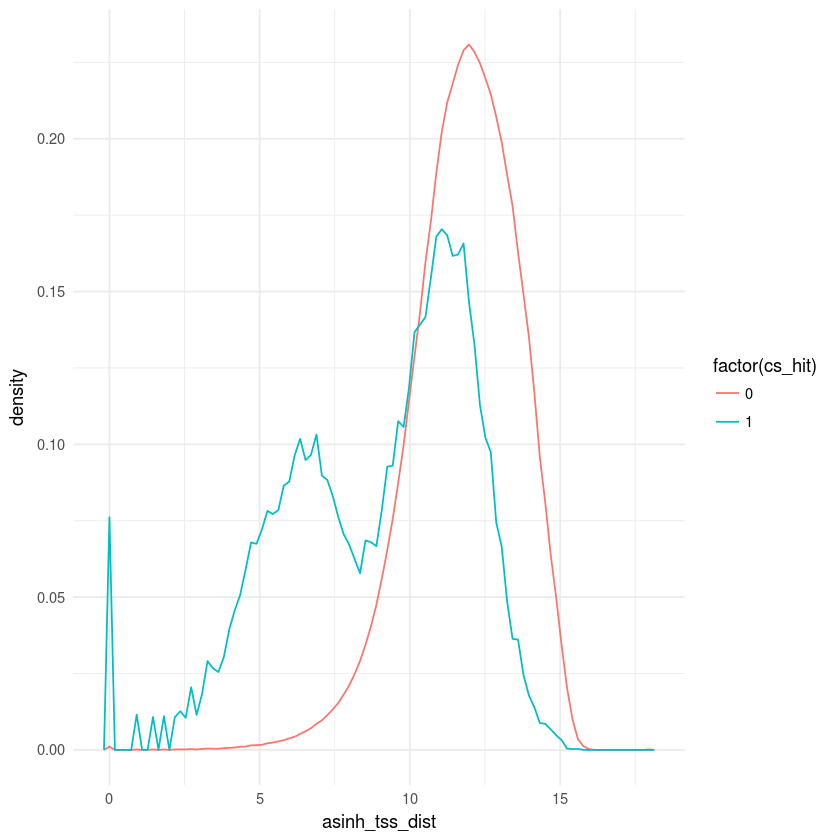

In [28]:
all.TF.df.fimo.hint.well.annotated %>%
ggplot +
geom_freqpoly(aes(x=asinh_tss_dist, y= ..density.., color=factor(cs_hit)), bins=100) +
theme_minimal()

2. Looking at distribution of GC content for ChipSeq positive/negative 

*Looks like ChipSeq hits tend to have higher GC content*

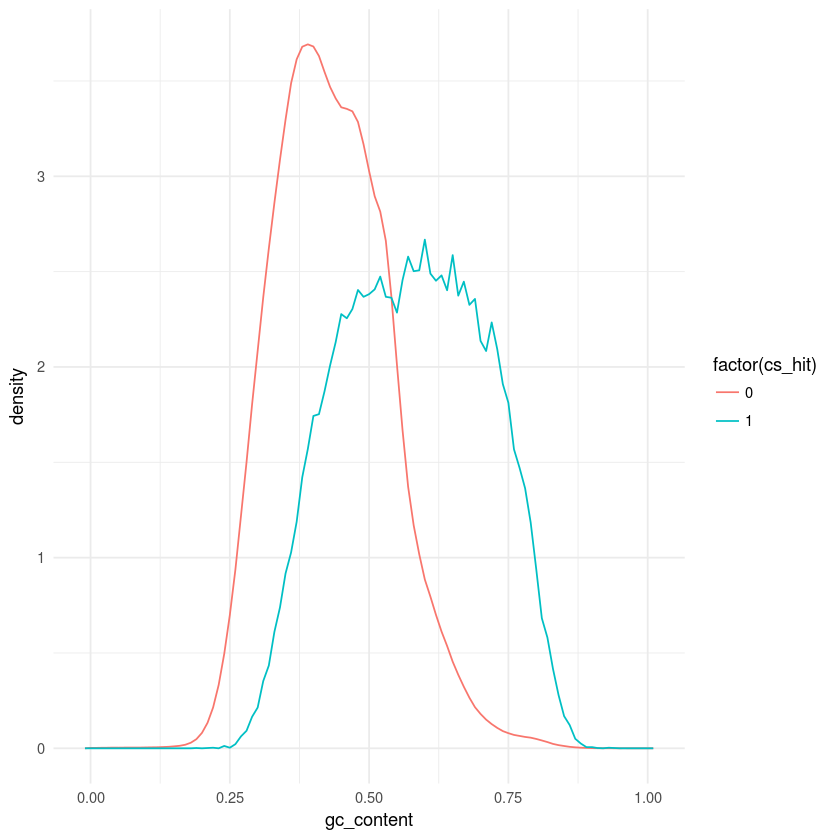

In [29]:
all.TF.df.fimo.hint.well.annotated %>%
ggplot +
geom_freqpoly(aes(x=gc_content, y= ..density.., color=factor(cs_hit)), bins=101) +
theme_minimal()

3. Looking at a scatterplot of GC content v. TSS distance for ChipSeq positive/negative. 

*Looks like we see 2 pretty distinct clusters, with higher distance from TSS and lower GC content corresponding to negative ChipSeq points.*

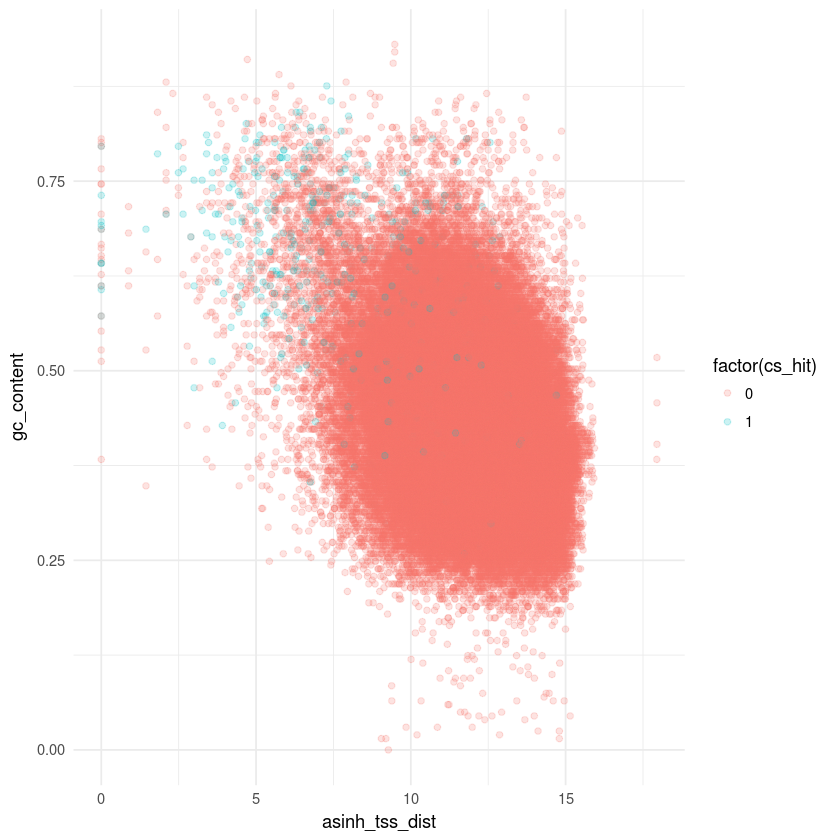

In [32]:
all.TF.df.fimo.hint.well.annotated %>%
sample_n(100000) %>%
ggplot +
geom_point(
    aes(x=asinh_tss_dist,
        y=gc_content,
        color=factor(cs_hit)),
    alpha=0.2) +
theme_minimal()